In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import sys
import os
import tqdm
import gc
import copy

from collections import defaultdict
import itertools

import plotly as ply
ply.io.renderers.default="notebook"

import ipywidgets as widgets
from ipywidgets import interact

import sklearn as skl
from sklearn.neighbors import KernelDensity

## Voltage PMF construction

### Load Raw data and compile joint table
For reference purposes, can skip this and run the next cell unless new data is needed

In [2]:
dataDir='../dataFiles'
neg200mV_file = '/'.join([dataDir,'neg200mV_cAMP_z.csv'])
neg200mV_data=pd.read_csv(neg200mV_file)
neg200mV_data=neg200mV_data.rename(columns={colName:'Frame' for colName in \
                     neg200mV_data.columns if 'Unnamed' in colName})
neg200mV_data=neg200mV_data.melt(id_vars='Frame',var_name='Ion_Index',
                               value_name='Z')
neg200mV_data['Potential']=-.2
neg200mV_data=neg200mV_data[['Potential','Frame','Ion_Index','Z']]
#display(neg200mV_data.head())

pos200mV_file = '/'.join([dataDir,'pos200mV_cAMP_z.csv'])
pos200mV_data=pd.read_csv(pos200mV_file)
pos200mV_data=pos200mV_data.rename(columns={colName:'Frame' for colName in \
                     pos200mV_data.columns if 'Unnamed' in colName})
pos200mV_data=pos200mV_data.melt(id_vars='Frame',var_name='Ion_Index',
                               value_name='Z')
pos200mV_data['Potential']=.2
pos200mV_data=pos200mV_data[['Potential','Frame','Ion_Index','Z']]
#display(pos200mV_data.head())

ionData=pd.concat([pos200mV_data,neg200mV_data])
del(pos200mV_data)
del(neg200mV_data)
display(ionData.head())

ionData.to_csv('/'.join([dataDir,'Ion_Coordinate_Data.csv']),
               index=False)

,Potential,Frame,Ion_Index,Z
0,0.2,0,1357,-25.384398
1,0.2,1,1357,-34.099881
2,0.2,2,1357,-41.649691
3,0.2,3,1357,-40.350572
4,0.2,4,1357,-39.439099


In [3]:
#dataDir='dataFiles'
#ionData=pd.read_csv('/'.join([dataDir,'Ion_Coordinate_Data.csv']))
print(ionData.tail())
ionData.describe()

        Potential  Frame Ion_Index          Z
267808       -0.2   9914      1383  32.534813
267809       -0.2   9915      1383  32.410938
267810       -0.2   9916      1383  32.711745
267811       -0.2   9917      1383  32.183560
267812       -0.2   9918      1383  32.497900


,Potential,Frame,Z
count,5.356260e+05,535626.000000,535626.000000
mean,-5.877305e-19,4959.000000,-15.116748
std,2.000002e-01,2863.371318,31.216550
min,-2.000000e-01,0.000000,-84.834234
25%,-2.000000e-01,2479.000000,-28.853932
50%,0.000000e+00,4959.000000,-22.914227
75%,2.000000e-01,7439.000000,-15.752646
max,2.000000e-01,9918.000000,83.019765


### Generate scatter plots of ion data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



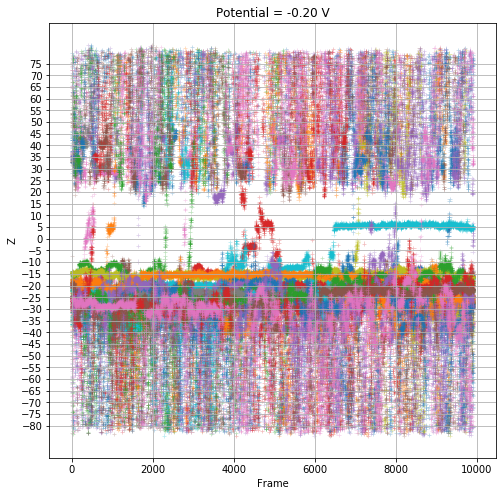

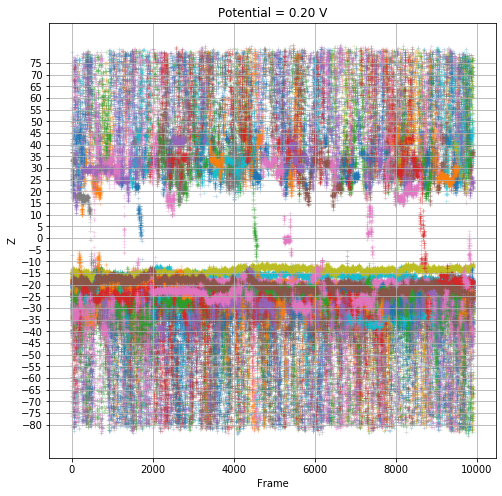

In [4]:
for potName,potData in ionData.groupby('Potential'):
  plt.figure(figsize=(8,8))
  for iName,iData in tqdm.tqdm_notebook(potData.groupby('Ion_Index')):
    sns.scatterplot(x='Frame',y='Z',data=iData,
                    size=0.2,legend=False,marker='+',
                    #label='Ion_%s'%iName,
                    alpha=.3)
  #plt.axhline(y=32, color='r', linestyle='-')
  #plt.axhline(y=-32,color='r',linestyle='-')
  plt.xlabel('Frame')
  plt.ylabel('Z')
  plt.yticks(np.arange(-80, 80, 5))
  plt.grid(True)
  plt.title('Potential = %.2f V'%potName)
  plt.show()

### Display Histograms of the ion coordinates

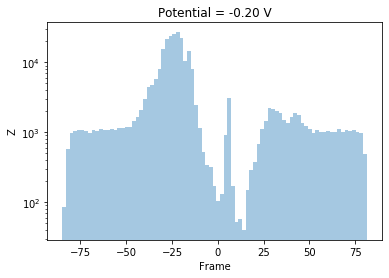

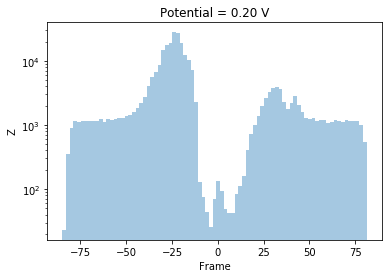

In [5]:
zBins=np.arange(ionData.Z.min(),ionData.Z.max(),2)
for potName,potData in ionData.groupby('Potential'):
  #for iName,iData in potData.groupby('Ion_Index'):
  #  sns.kdeplot(iData.Z,
  #               label='Ion_%s'%iName,alpha=.5)
  sns.distplot(potData.Z,bins=zBins,norm_hist=False,kde=False,
              label='Joint_Density')
  plt.xlabel('Frame')
  plt.ylabel('Z')
  plt.title('Potential = %.2f V'%potName)
  plt.yscale('log')
  plt.show()

### Display some overview statistics of the full data set and binned data

In [6]:
for potVal,potData in ionData.groupby('Potential'):
    print('potential =',potVal*1000,'mV')
    display(potData.Z.describe())
    binWidth=2
zBins=np.arange(-75,75+binWidth,binWidth)
zBins
display(ionData[['Potential','Z']].groupby(['Potential']).agg(
    lambda x: np.min(np.histogram(x,bins=zBins)[0])))
display(ionData[['Potential','Z']].groupby(['Potential']).agg(
    lambda x: np.max(np.histogram(x,bins=zBins)[0])))
display(ionData[['Potential','Z']].groupby(['Potential']).agg(len))

potential = -200.0 mV


count    267813.000000
mean        -16.372790
std          29.927054
min         -84.336787
25%         -28.726879
50%         -23.046127
75%         -16.131300
max          83.019765
Name: Z, dtype: float64

potential = 200.0 mV


count    267813.000000
mean        -13.860706
std          32.406261
min         -84.834234
25%         -28.993487
50%         -22.793476
75%         -15.217315
max          82.769893
Name: Z, dtype: float64

,Z
Potential,
-0.2,43.0
0.2,26.0


,Z
Potential,
-0.2,27257.0
0.2,28343.0


,Z
Potential,
-0.2,267813.0
0.2,267813.0


## Plot Full Data Set PMF

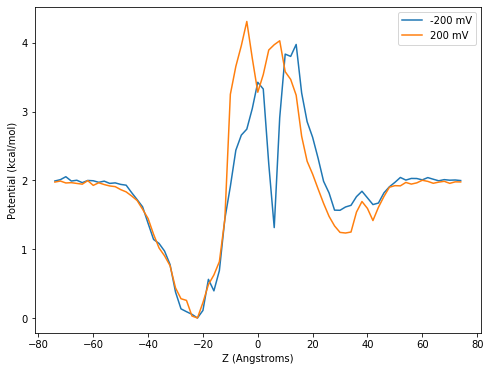

,Simulation_Potential,Z,Density,PMF
0,-0.2,-74.0,0.004117,1.991447
1,-0.2,-72.0,0.003991,2.010627
2,-0.2,-70.0,0.003724,2.053403
3,-0.2,-68.0,0.004121,1.990875
4,-0.2,-66.0,0.004045,2.002417


In [7]:
binWidth=2.0
zMin=-75
zMax=75
zBins=np.arange(zMin,zMax+binWidth,binWidth)
zMids=(zBins[1:]+zBins[:-1])/2.
kb=0.0019872041
simTemp=310.15
kbT=simTemp*kb
plt.figure(figsize=(8,6))
pmfFrames=[]
for potVal,potData in ionData.groupby('Potential'):
    histData=np.histogram(potData.Z,zBins)
    histDens=histData[0]/np.sum(histData[0])
    histPMF=-kbT*np.log(histDens)
    histPMF=histPMF-np.min(histPMF)
    sns.lineplot(zMids,histPMF,label='%g mV'%(int(potVal*1000)))
    pmfFrames.append(pd.DataFrame({
        'Simulation_Potential':[potVal]*len(zMids),
        'Z':zMids,
        'Density':histDens,
        'PMF':histPMF
    }).copy())
plt.xlabel('Z (Angstroms)')
plt.ylabel('Potential (kcal/mol)')
plt.show()
pmfData=pd.concat(pmfFrames)
pmfFrames=[]
pmfData.to_csv('/'.join([dataDir,'Ion_PMF_Data.csv']),index=False)
pmfData.head()

## Perform bootstrap PMF error analysis

Because we are sampling from a distribution with large differences between the maximum and minimum density over our bins, we need to be prepared for cases where a bin is not sampled in a given bootstrap sample.
To handle this, we will aggregate our mean and quantile statistics for the corresponding bootstrapped pmfs using the np.nanmean and np.nanquantile, which will automatically ignore bins with undefined values (e.g. where the count was zero and the log operation failed)

### Construct Bootstrapped PMF data set
Bootstrapping is used to construct 95% confidence intervals for the ion density based PMF for each of the external voltage simulations using the Monte-Carlo case resampling with a total of 1000 bootstrap samples. I.e. each bootstrap sample is constructed by resampling the original dataset, with replacement, to draw a new sample of equal size. For each bootstrap sample, the density is constructed in the same manner as the full data set above. The z-coordinate data is first binned into a histogram spanning z $\in$ [-75,75] with 2 angstrom bin widths. This histogram is then normalized to form a binned density. The binned density is then converted to a PMF as $PMF(z_i)=-kb*T*log{\rho(z_i)}-Min(PMF)$ where $PMF(z_i)$ and $\rho(z_i)$ are the PMF and density for bin $z_i$ and $Min(PMF)$ is the minimum value of the PMF over all bins. The mean and $q=\alpha / 2$ and $q=1-\alpha / 2$ quantiles of the bootstrapped PMF distributions for each bin are then calculated. The $q=\alpha / 2$ quantile and $q=1-\alpha / 2$ quantile (with $\alpha=.05$ for the 95% confidence interval being constructed) serve as the lower and upper $1-\alpha / 2$ confidence level bounds for each bin.

In [8]:
nBootSamples=1000
binWidth=2.0
zMin=-75
zMax=75
zBins=np.arange(zMin,zMax+binWidth,binWidth)
zMids=(zBins[1:]+zBins[:-1])/2.
bandwidth=binWidth
#KDE=KernelDensity(bandwidth=bandwidth) #this is too slow with such large data sets
bootDataFrames=[]
kb=0.0019872041
simTemp=310.15
kbT=simTemp*kb
for potVal,potData in ionData.groupby('Potential'):
    for iBoot in tqdm.tqdm_notebook(
        np.arange(nBootSamples),desc='Bootstrapping %f V data'%potVal):
        #KDE.fit(
        #    ionData.query(
        #        'Potential==%f'%potVal
        #        )['Z'].sample(replace=True,frac=.25).to_numpy().reshape(-1,1))
        #distDat=np.array(list(map(lambda x: KDE.score(np.array([x]).reshape(-1,1)),
        #                  zBins)))
        #distDat=np.exp(distDat)/np.sum(np.exp(distDat))
        #bootData.append(copy.deepcopy(distDat))
        bootHist=np.histogram(potData.Z.sample(frac=1.0,replace=True),zBins)
        bootDens=bootHist[0]/np.sum(bootHist[0])
        bootPMF=-kbT*np.log(bootDens)
        bootPMF=bootPMF-np.min(bootPMF)
        bootDataFrames.append(pd.DataFrame({
            'Simulation_Potential':[potVal]*len(zMids),
            'Bootsample_Index':[iBoot]*len(zMids),
            'Z':zMids,
            'Density':copy.deepcopy(bootDens),
            'PMF':copy.deepcopy(bootPMF)
        }).copy())

bootDataFrame=pd.concat(bootDataFrames)
bootDataFrames=[]
bootDataFrame.to_csv('/'.join([dataDir,'Bootstrapping_PMF_Data.csv']),index=False)
bootDataFrame.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



,Simulation_Potential,Bootsample_Index,Z,Density,PMF
0,-0.2,0,-74.0,0.004083,1.997026
1,-0.2,0,-72.0,0.004109,1.993000
2,-0.2,0,-70.0,0.003704,2.056982
3,-0.2,0,-68.0,0.003922,2.021753
4,-0.2,0,-66.0,0.004102,1.994148


## Use bootstrap data to constuct a quantile based confidence interval estimate

In [9]:
aVal=.05
def upper(x):
    return np.nanquantile(x,q=1-aVal/2)
def lower(x):
    return np.nanquantile(x,q=aVal/2)
def Mean(x):
    return np.nanmean(x)
    
bootPMFsummary=bootDataFrame.groupby(
        ['Simulation_Potential','Z']
    ).agg({
        'Density':(Mean,upper,lower),
        'PMF':(Mean,upper,lower)
    })
bootPMFsummary.columns=bootPMFsummary.columns.map(lambda x: '_'.join(x))
bootPMFsummary=bootPMFsummary.reset_index()
bootPMFsummary.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

Mean of empty slice

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning:

Mean of empty slice



,Simulation_Potential,Z,Density_Mean,Density_upper,Density_lower,PMF_Mean,PMF_upper,PMF_lower
0,-0.2,-74.0,0.004115,0.004374,0.003872,1.992194,2.030180,1.952538
1,-0.2,-72.0,0.003992,0.004240,0.003762,2.010799,2.048612,1.972377
2,-0.2,-70.0,0.003729,0.003956,0.003490,2.052901,2.093666,2.015675
3,-0.2,-68.0,0.004122,0.004370,0.003887,1.991065,2.028369,1.954038
4,-0.2,-66.0,0.004041,0.004284,0.003812,2.003256,2.038908,1.965509


## Merge Bootstrapping confidence interval results with full data set pmf data frame

In [10]:
pmfAnalysisData=pmfData.set_index(['Simulation_Potential','Z']).join(
    other=bootPMFsummary.set_index(['Simulation_Potential','Z']),
    lsuffix='FullData',
    rsuffix='Bootstrap')
pmfAnalysisData=pmfAnalysisData.rename(
    columns={colName:'Bootstrap_'+colName for colName in pmfAnalysisData.columns \
             if '_' in colName})
pmfAnalysisData=pmfAnalysisData.reset_index()
pmfAnalysisData.to_csv('/'.join([dataDir,'PMF_Analysis_Summary.csv']))
pmfAnalysisData.head()

,Simulation_Potential,Z,Density,PMF,Bootstrap_Density_Mean,Bootstrap_Density_upper,Bootstrap_Density_lower,Bootstrap_PMF_Mean,Bootstrap_PMF_upper,Bootstrap_PMF_lower
0,-0.2,-74.0,0.004117,1.991447,0.004115,0.004374,0.003872,1.992194,2.030180,1.952538
1,-0.2,-72.0,0.003991,2.010627,0.003992,0.004240,0.003762,2.010799,2.048612,1.972377
2,-0.2,-70.0,0.003724,2.053403,0.003729,0.003956,0.003490,2.052901,2.093666,2.015675
3,-0.2,-68.0,0.004121,1.990875,0.004122,0.004370,0.003887,1.991065,2.028369,1.954038
4,-0.2,-66.0,0.004045,2.002417,0.004041,0.004284,0.003812,2.003256,2.038908,1.965509


In [65]:
pmfAnalysisData.tail()

,Simulation_Potential,Z,Density,PMF,Bootstrap_Density_Mean,Bootstrap_Density_upper,Bootstrap_Density_lower,Bootstrap_PMF_Mean,Bootstrap_PMF_upper,Bootstrap_PMF_lower
145,0.2,66.0,0.004397,1.975107,0.004397,0.004660,0.004150,1.975498,2.011692,1.938693
146,0.2,68.0,0.004313,1.987012,0.004320,0.004570,0.004084,1.986480,2.021057,1.951080
147,0.2,70.0,0.004527,1.957149,0.004519,0.004778,0.004263,1.958644,1.997086,1.924171
148,0.2,72.0,0.004370,1.978870,0.004373,0.004621,0.004114,1.978909,2.016281,1.943508
149,0.2,74.0,0.004378,1.977792,0.004374,0.004629,0.004120,1.978720,2.015966,1.943313


## Plot the results

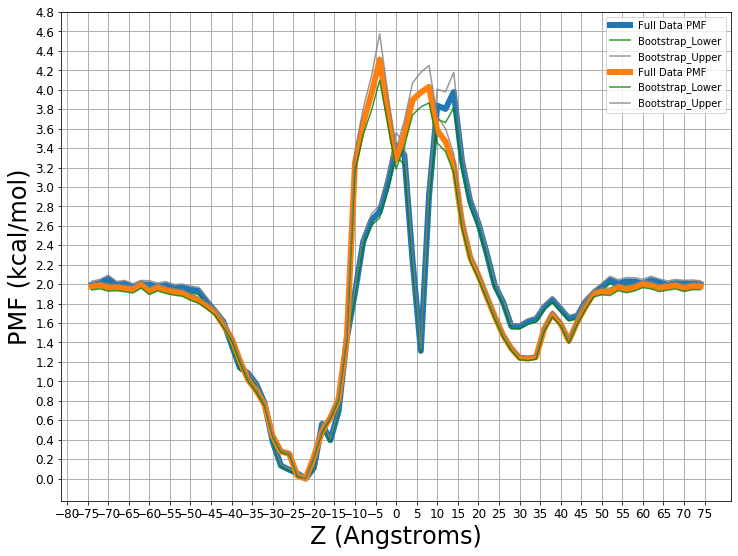

In [11]:
plt.figure(figsize=(12,9))
bootpmfFrames=[]
for potVal,potData in pmfAnalysisData.groupby('Simulation_Potential'):  
    sns.lineplot(data=potData,x='Z',y='PMF',
                 label='Full Data PMF',linewidth=6)
    #sns.lineplot(data=potData,x='Z',y='Bootstrap_PMF_Mean',
     #            color='red',label='Bootstrap PMF',alpha=.5)
    sns.lineplot(data=potData,x='Z',y='Bootstrap_PMF_lower',
                 color='green',label='Bootstrap_Lower',alpha=.8)
    sns.lineplot(data=potData,x='Z',y='Bootstrap_PMF_upper',
                 color='grey',label='Bootstrap_Upper',alpha=.8)
   
    #plt.title('%g mV Simulation PMF Analysis'%(potVal*1000))
plt.xlabel('Z (Angstroms)',size=24)
plt.ylabel('PMF (kcal/mol)',size=24)
plt.xticks(np.arange(-80,80,5),size=12)
plt.yticks(np.arange(0,5,0.2),size=12)
plt.grid(linestyle="-",linewidth=1)
plt.show()

# Apply PME based correction term to recover equilibrium PMFs

In [12]:
import gridData
from gridData import Grid

In [13]:
print('Loading PME Grid Data')
pmeFileNames=[filename for filename in tqdm.tqdm_notebook(os.listdir(dataDir),\
              desc='scanning for pme data') \
              if ('_noLigand' in filename) and ('PME.dx' in filename)]
print(pmeFileNames)

Loading PME Grid Data


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




['n200mV_noLigand.first_10ns.all.PME.dx', 'noField_noLigand.first_10ns.all.PME.dx', 'p200mV_noLigand.first_10ns.all.PME.dx']


In [14]:
pmeDict={filename.split('.')[0]:Grid(dataDir+'/'+filename) \
    for filename in tqdm.tqdm_notebook(pmeFileNames,\
    desc='Loading pmeFileNames')
}
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [15]:
!ls ../dataFiles

Bootstrapping_PMF_Data.csv
Ion_Coordinate_Data.csv
Ion_PMF_Data.csv
PMF_Analysis_Summary.csv
n200mV.last_1000_frames.imaged.cAMP_ChargeDensity.dx
n200mV_delta.first_10ns.all.PME.dx
n200mV_noLigand.first_10ns.all.PME.dx
neg200mV_cAMP_z.csv
noField_noLigand.first_10ns.all.PME.dx
p200mV.last_1000_frames.imaged.cAMP_ChargeDensity.dx
p200mV_delta.first_10ns.all.PME.dx
p200mV_noLigand.first_10ns.all.PME.dx
pos200mV_cAMP_z.csv


In [16]:
chargeDensityFileNames=[
    filename for filename in tqdm.tqdm_notebook(os.listdir(dataDir),desc='scanning for charge density data') \
    if 'cAMP_ChargeDensity.dx' in filename
]
print(chargeDensityFileNames)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




['n200mV.last_1000_frames.imaged.cAMP_ChargeDensity.dx', 'p200mV.last_1000_frames.imaged.cAMP_ChargeDensity.dx']


In [17]:
chargeDensityDict={
    filename.split('.')[0]:Grid(dataDir+'/'+filename) \
    for filename in tqdm.tqdm_notebook(chargeDensityFileNames,\
    desc='Loading Charge Density data')
}

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [18]:
print(chargeDensityDict)

{'n200mV': <<class 'gridData.core.Grid'> with (154, 153, 194) bins>, 'p200mV': <<class 'gridData.core.Grid'> with (153, 153, 195) bins>}


In [19]:
print('Charge Density data Dict:')
#check to ensure that the grids have roughly the same center and origin
for gridName,gridData in chargeDensityDict.items():
    print(gridName,gridData,
          'origin:',gridData.origin,
          '; center:',gridData.origin+gridData.delta*np.array(gridData.grid.shape)/2)

Charge Density data Dict:
n200mV <<class 'gridData.core.Grid'> with (154, 153, 194) bins> origin: [-76.5 -76.5 -96.5] ; center: [0.5 0.  0.5]
p200mV <<class 'gridData.core.Grid'> with (153, 153, 195) bins> origin: [-15.5 -15.5 -15.5] ; center: [61. 61. 82.]


In [20]:
pmeDeltaFiles=[filename for filename in \
               tqdm.tqdm_notebook(os.listdir(dataDir),desc='Scanning for delta PME data') \
               if ('delta' in filename) and ('PME.dx' in filename)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [21]:
pmeDeltaDict={
    filename.split('.')[0].split('_')[0]: Grid(dataDir+'/'+filename) \
    for filename in tqdm.tqdm_notebook(pmeDeltaFiles,desc='Loading delta PME data')
}

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [22]:
for gridName,gridData in pmeDeltaDict.items():
    print(gridName,gridData,
          'origin:',gridData.origin,
          '; center:',gridData.origin+gridData.delta*np.array(gridData.grid.shape)/2)

n200mV <<class 'gridData.core.Grid'> with (128, 128, 160) bins> origin: [-60.3575 -60.2207 -77.0848] ; center: [0.475268 0.474148 0.48488 ]
p200mV <<class 'gridData.core.Grid'> with (128, 128, 160) bins> origin: [-60.3575 -60.2207 -77.0848] ; center: [0.475268 0.474148 0.48488 ]


In [23]:
fileNameFilter='.dx'
@interact
def plotGrid(gridName=[filename for filename in os.listdir(dataDir) \
                       if fileNameFilter in filename],
             crossSection=['XY','XZ','YZ'],
             offset=widgets.FloatSlider(min=-.5,max=.5,value=0.)):
    tempGrid=Grid(dataDir+'/'+gridName)
    tempGridCenter=tempGrid.origin + (tempGrid.delta*np.array(tempGrid.grid.shape))/2
    print(tempGrid.origin,tempGridCenter,tempGrid.delta)
    tempGrid.origin=tempGrid.origin - tempGridCenter
    tempGridCenter=tempGrid.origin + (tempGrid.delta*np.array(tempGrid.grid.shape))/2
    print(tempGrid.origin,tempGridCenter)
    if crossSection=='XY':
        offsetIndex=int(tempGrid.grid.shape[2]*(.5+offset))
        plotData=tempGrid.grid[:,:,offsetIndex]
    elif crossSection=='XZ':
        offsetIndex=int(tempGrid.grid.shape[1]*(.5+offset))
        plotData=tempGrid.grid[:,offsetIndex,:]
    else:
        offsetIndex=int(tempGrid.grid.shape[0]*(.5+offset))
        plotData=tempGrid.grid[offsetIndex,:,:]
    scaleFactor=25.7*310.15/298
    sns.heatmap(plotData*scaleFactor,center=0)
    plt.show()

interactive(children=(Dropdown(description='gridName', options=('n200mV.last_1000_frames.imaged.cAMP_ChargeDen…

### Test adding back the field potential gradient

In [24]:
#To add 0.2V across z to the pmeGrid (unit kBT/e), charge density unit e/A^3
kb=0.0019872041
simTemp=310.15
kbT=simTemp*kb
print(kbT)
#1eV=23.061 kcal/mol
eV=23.061*kbT
print("1ev is",eV,"in kbT/mol")


0.6163313516149999
1ev is 14.213217299593511 in kbT/mol


(128, 128, 160) [0.950512 0.948357 0.969621]
(128, 128, 160) [0.949934 0.94778  0.969189]
(128, 128, 160) [0.949934 0.94778  0.969189]


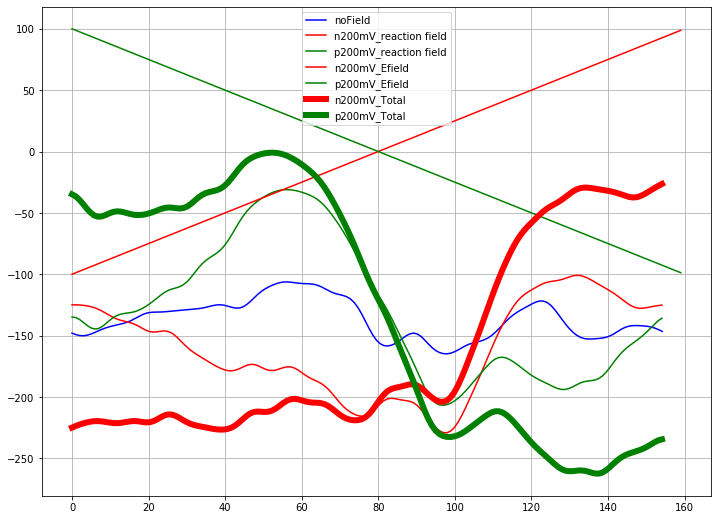

In [31]:
plt.figure(figsize=(12,9))
scaleFactor=25.7*310.15/298

tempGrid_0V=pmeDict['noField_noLigand']*scaleFactor
print(tempGrid_0V.grid.shape, tempGrid_0V.delta)
sns.lineplot(np.arange(tempGrid_0V.grid.shape[2])*tempGrid_0V.delta[2],\
             tempGrid_0V.grid[64,64,:],color='b',label="noField")

tempGrid_n200=pmeDict['n200mV_noLigand']*scaleFactor
print(tempGrid_n200.grid.shape, tempGrid_n200.delta)
sns.lineplot(np.arange(tempGrid_n200.grid.shape[2])*tempGrid_n200.delta[2],\
             tempGrid_n200.grid[64,64,:],color='r',label="n200mV_reaction field")
tempGrid_p200=pmeDict['p200mV_noLigand']*scaleFactor
print(tempGrid_p200.grid.shape, tempGrid_p200.delta)
sns.lineplot(np.arange(tempGrid_p200.grid.shape[2])*tempGrid_p200.delta[2],\
             tempGrid_p200.grid[64,64,:],color='g',label="p200mV_reaction field")

tempGrid_n200b=pmeDict['n200mV_noLigand']*scaleFactor
tempGridCenter_n200b=tempGrid_n200b.origin+tempGrid_n200b.delta*np.array(tempGrid_n200b.grid.shape)/2
tempGrid_n200b.grid=tempGrid_n200b.grid+(
    (-tempGridCenter_n200b[2]+tempGrid_n200b.midpoints[2])*(200) / \
    (tempGrid_n200b.delta[2]*tempGrid_n200b.grid.shape[2]))
plt.plot((-tempGridCenter_n200b[2]+tempGrid_n200b.midpoints[2])*(200)/ \
         (tempGrid_n200b.delta[2]*tempGrid_n200b.grid.shape[2]),color='r',label="n200mV_Efield")

tempGrid_p200b=pmeDict['p200mV_noLigand']*scaleFactor
tempGridCenter_p200b=tempGrid_p200b.origin+tempGrid_p200b.delta*np.array(tempGrid_p200b.grid.shape)/2
tempGrid_p200b.grid=tempGrid_p200b.grid+(
    (tempGridCenter_p200b[2]-tempGrid_p200b.midpoints[2])*(200) / \
    (tempGrid_p200b.delta[2]*tempGrid_p200b.grid.shape[2]))
plt.plot((tempGridCenter_p200b[2]-tempGrid_p200b.midpoints[2])*(200)/ \
         (tempGrid_p200b.delta[2]*tempGrid_p200b.grid.shape[2]),color='g',label="p200mV_Efield")



sns.lineplot(np.arange(tempGrid_n200b.grid.shape[2])*tempGrid_n200b.delta[2],\
             tempGrid_n200b.grid[64,64,:],linewidth=6,label="n200mV_Total",color='r')
sns.lineplot(np.arange(tempGrid_p200b.grid.shape[2])*tempGrid_p200b.delta[2],\
             tempGrid_p200b.grid[64,64,:],linewidth=6,label="p200mV_Total",color='g')
plt.grid(True)
plt.show()

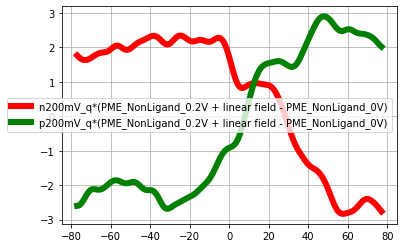

In [127]:
#q*(PME_NonLigand_0.2V + linear field - PME_NonLigand_0V) 1mV=0.023kcal/mol/e
#print(np.arange(tempGrid_n200b.grid.shape[2])*tempGrid_n200b.delta[2]-77)
sns.lineplot(np.arange(tempGrid_n200b.grid.shape[2])*tempGrid_n200b.delta[2]-77,\
             -0.023*(tempGrid_n200b.grid[64,64,:]-tempGrid_0V.grid[64,64,:]),linewidth=6,label="n200mV_q*(PME_NonLigand_0.2V + linear field - PME_NonLigand_0V)",color='r')
sns.lineplot(np.arange(tempGrid_p200b.grid.shape[2])*tempGrid_p200b.delta[2]-77,\
             -0.023*(tempGrid_p200b.grid[64,64,:]-tempGrid_0V.grid[64,64,:]),linewidth=6,label="p200mV_q*(PME_NonLigand_0.2V + linear field - PME_NonLigand_0V)",color='g')
plt.grid(True)
plt.show()

In [123]:
PMF_0V=pd.read_csv('PMF_0V.csv',header=None)
PMF_0V.rename(columns={0:'z',1:'E'},inplace=True)
#print(PMF_0V)
windowCenters=[-69.6,-67.6,-65.6,-63.6,-61.6,-59.6,-57.6,-55.6,-53.6,-51.6,-49.6,-47.6,-45.6,-43.6,-41.6,-39.6,-37.6,-35.6,-33.6,-31.6,-29.6,-27.6,-25.6,-23.6,-21.6,-19.6,-17.6,-15.6,-13.6,-11.6,-9.6,-7.6,-5.6,-3.6,-1.6,0.4,2.4,4.4,6.4,8.4,10.4,12.4,14.4,16.4,18.4,20.4,22.4,24.4,26.4,28.4,30.4,32.4,34.4,36.4,38.4,40.4,42.4,44.4,46.4,48.4,50.4,52.4,54.4,56.5,58.4,60.4,62.4,64.4,66.4,68.4,70.4,72.4]

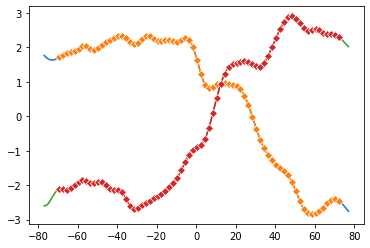

In [124]:
x_n200b,y_n200b=np.arange(tempGrid_n200b.grid.shape[2])*tempGrid_n200b.delta[2]-77,\
             -0.023*(tempGrid_n200b.grid[64,64,:]-tempGrid_0V.grid[64,64,:])
xi=windowCenters
yi_n200b=np.interp(xi,x_n200b, y_n200b)
sns.lineplot(x_n200b, y_n200b,marker='')
sns.lineplot(xi, yi_n200b,marker='D')

x_p200b,y_p200b=np.arange(tempGrid_p200b.grid.shape[2])*tempGrid_p200b.delta[2]-77,\
             -0.023*(tempGrid_p200b.grid[64,64,:]-tempGrid_0V.grid[64,64,:])
xi=windowCenters
yi_p200b=np.interp(xi,x_p200b, y_p200b)
sns.lineplot(x_p200b, y_p200b,marker='')
sns.lineplot(xi, yi_p200b,marker='D')


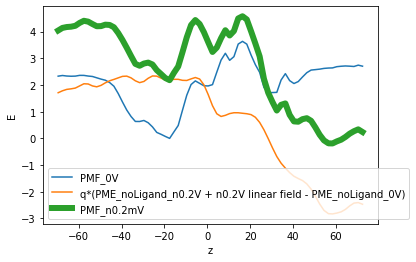

In [121]:
# PME_0V + q*(PME_NonLigand_0.2V + linear field - PME_NonLigand_0V)
#plt.figure(figsize=(12,9))
sns.lineplot(data=PMF_0V,x='z',y='E',
                 label='PMF_0V')
sns.lineplot(xi, yi_n200b,label='q*(PME_noLigand_n0.2V + n0.2V linear field - PME_noLigand_0V)')

PMF_tot=PMF_0V.E + yi_n200b
#print(PMF_tot, PMF_0V.E,yi_n200b)

sns.lineplot(xi,PMF_tot,
                label='PMF_n0.2mV',linewidth=6)    


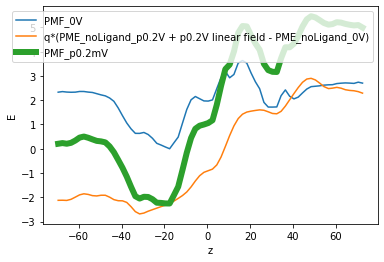

In [125]:
# PME_0V + q*(PME_NonLigand_0.2V + linear field - PME_NonLigand_0V)
#plt.figure(figsize=(12,9))
sns.lineplot(data=PMF_0V,x='z',y='E',
                 label='PMF_0V')
sns.lineplot(xi, yi_p200b,label='q*(PME_noLigand_p0.2V + p0.2V linear field - PME_noLigand_0V)')

PMF_tot=PMF_0V.E + yi_p200b
#print(PMF_tot, PMF_0V.E,yi_n200b)

sns.lineplot(xi,PMF_tot,
                label='PMF_p0.2mV',linewidth=6)    

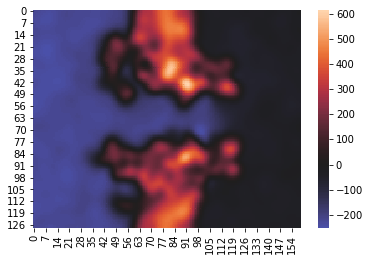

In [27]:
offset=0.0
offsetIndex=int(tempGrid_n200b.grid.shape[1]*(.5+offset))
plotData=tempGrid_n200b.grid[:,offsetIndex,:]
sns.heatmap(plotData,center=0)
plt.show()

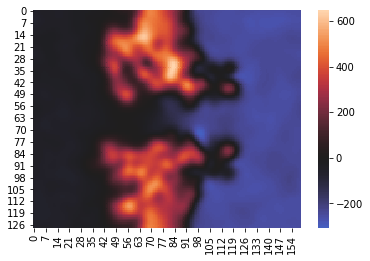

In [28]:
offset=0.0
offsetIndex=int(tempGrid_p200b.grid.shape[1]*(.5+offset))
plotData=tempGrid_p200b.grid[:,offsetIndex,:]
sns.heatmap(plotData,center=0)
plt.show()